### Warper model to pick either GRU or LSTM at each day

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV #cross_valid
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import datetime
from scipy.spatial import distance
from numba import jit
from scipy.stats import norm
import collections
import pandas.io.sql as sqlio
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

import seaborn as sns
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
df = pd.read_csv('avg_infected_obs_all_pred_Nov20.csv')
print(df.shape)
df.head()

(660, 10)


,Date,Observed_cases,Pred_GRU_1,Pred_GRU_2,Pred_GRU_3,Pred_mean_GRU,Pred_LSTM_1,Pred_LSTM_2,Pred_LSTM_3,Pred_mean_LSTM
0,2020-01-31,0,0,0,0,0,0,1,1,1
1,2020-02-01,0,5,5,2,4,3,2,3,3
2,2020-02-02,0,0,0,0,0,0,1,0,0
3,2020-02-03,0,1,3,2,2,0,1,1,1
4,2020-02-04,1,0,0,1,0,0,1,1,1


#### 0 LSTM
#### 1 GRU

In [3]:
def lstm_or_gru(obs,lstm,gru):
    lstm_err = abs(obs - lstm) #absolute err
    gru_err = abs(obs - gru)
    if(lstm_err < gru_err): return 0 # lstm
    else: return 1 # gru

In [4]:
res = [] # 0 or 1
for index, row in df.iterrows():
    res.append(lstm_or_gru(row['Observed_cases'], row['Pred_mean_LSTM'], row['Pred_mean_GRU']))
df['Y'] = res

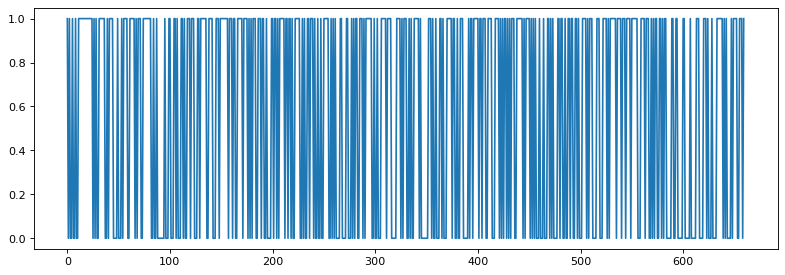

In [5]:
from matplotlib.pyplot import figure
figure(figsize=(12, 4), dpi=80)
plt.plot(res)


(array([290.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 370.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

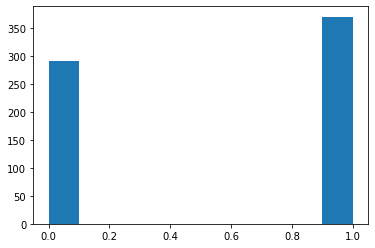

In [6]:
plt.hist(res)

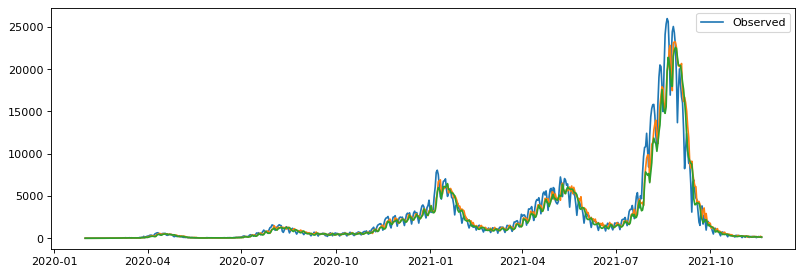

In [7]:
from matplotlib.pyplot import figure
figure(figsize=(12, 4), dpi=80)
time = pd.to_datetime(df['Date'])
plt.plot(time,df['Observed_cases'], label='Observed')
plt.plot(time,df['Pred_mean_GRU'])
plt.plot(time,df['Pred_mean_LSTM'])
plt.legend()

In [18]:
split_point = int(len(df)*7/10)
split_point

462

In [19]:
df.head()

,Date,Observed_cases,Pred_GRU_1,Pred_GRU_2,Pred_GRU_3,Pred_mean_GRU,Pred_LSTM_1,Pred_LSTM_2,Pred_LSTM_3,Pred_mean_LSTM,Y
0,2020-01-31,0,0,0,0,0,0,1,1,1,1
1,2020-02-01,0,5,5,2,4,3,2,3,3,0
2,2020-02-02,0,0,0,0,0,0,1,0,0,1
3,2020-02-03,0,1,3,2,2,0,1,1,1,0
4,2020-02-04,1,0,0,1,0,0,1,1,1,0


In [20]:
X = df[['Pred_GRU_1', 'Pred_GRU_2', 'Pred_GRU_3', 'Pred_mean_GRU', 'Pred_LSTM_1', 'Pred_LSTM_2', 'Pred_LSTM_3', 'Pred_mean_LSTM']]
Y = df['Y']
print(X.shape, Y.shape)

(660, 8) (660,)


In [21]:
X

,Pred_GRU_1,Pred_GRU_2,Pred_GRU_3,Pred_mean_GRU,Pred_LSTM_1,Pred_LSTM_2,Pred_LSTM_3,Pred_mean_LSTM
0,0,0,0,0,0,1,1,1
1,5,5,2,4,3,2,3,3
2,0,0,0,0,0,1,0,0
3,1,3,2,2,0,1,1,1
4,0,0,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...
655,156,135,151,147,158,153,131,147
656,189,170,158,172,153,160,108,140
657,125,172,183,160,162,149,90,134
658,243,234,233,237,166,136,102,135


In [22]:
X_train = X[:split_point]
y_train = Y[:split_point]

X_val = X[split_point:]
y_val = Y[split_point:]
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(462, 8) (462,)
(198, 8) (198,)


In [23]:
# binary classifying
clf_xbg = xgb.XGBClassifier(objective='binary:logistic')
train_process = clf_xbg.fit(X_train, y_train, verbose=True, early_stopping_rounds=200,
                            eval_metric='auc', eval_set=[(X_val, y_val)])

[0]	validation_0-auc:0.51555
[1]	validation_0-auc:0.56542
[2]	validation_0-auc:0.58731
[3]	validation_0-auc:0.56756
[4]	validation_0-auc:0.58127
[5]	validation_0-auc:0.55488
[6]	validation_0-auc:0.55150
[7]	validation_0-auc:0.54910
[8]	validation_0-auc:0.54639
[9]	validation_0-auc:0.55053
[10]	validation_0-auc:0.55053
[11]	validation_0-auc:0.55053
[12]	validation_0-auc:0.53110
[13]	validation_0-auc:0.53974
[14]	validation_0-auc:0.53386
[15]	validation_0-auc:0.53841
[16]	validation_0-auc:0.54071
[17]	validation_0-auc:0.54670
[18]	validation_0-auc:0.54700
[19]	validation_0-auc:0.54598
[20]	validation_0-auc:0.54838
[21]	validation_0-auc:0.55242
[22]	validation_0-auc:0.55457
[23]	validation_0-auc:0.55805
[24]	validation_0-auc:0.55099
[25]	validation_0-auc:0.54255
[26]	validation_0-auc:0.54148
[27]	validation_0-auc:0.54148
[28]	validation_0-auc:0.54813
[29]	validation_0-auc:0.54056
[30]	validation_0-auc:0.54240
[31]	validation_0-auc:0.53846
[32]	validation_0-auc:0.53631
[33]	validation_0-au

C:\Users\maidu\.conda\envs\tf\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[65]	validation_0-auc:0.52240
[66]	validation_0-auc:0.52148
[67]	validation_0-auc:0.52148
[68]	validation_0-auc:0.52148
[69]	validation_0-auc:0.51821
[70]	validation_0-auc:0.51995
[71]	validation_0-auc:0.51985
[72]	validation_0-auc:0.52036
[73]	validation_0-auc:0.51821
[74]	validation_0-auc:0.51821
[75]	validation_0-auc:0.52015
[76]	validation_0-auc:0.51708
[77]	validation_0-auc:0.51565
[78]	validation_0-auc:0.51729
[79]	validation_0-auc:0.51739
[80]	validation_0-auc:0.51739
[81]	validation_0-auc:0.51739
[82]	validation_0-auc:0.51739
[83]	validation_0-auc:0.51739
[84]	validation_0-auc:0.51729
[85]	validation_0-auc:0.51729
[86]	validation_0-auc:0.51647
[87]	validation_0-auc:0.51626
[88]	validation_0-auc:0.51626
[89]	validation_0-auc:0.51626
[90]	validation_0-auc:0.51626
[91]	validation_0-auc:0.51626
[92]	validation_0-auc:0.51626
[93]	validation_0-auc:0.51626
[94]	validation_0-auc:0.51626
[95]	validation_0-auc:0.51667
[96]	validation_0-auc:0.51606
[97]	validation_0-auc:0.51616
[98]	valid

In [14]:
y_pred = clf_xbg.predict(X_val)

<AxesSubplot:>

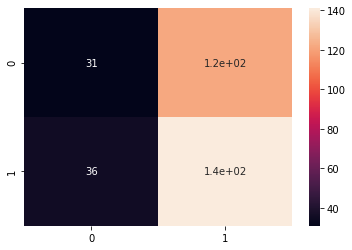

In [15]:
cf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(cf_matrix, annot=True)

C:\Users\maidu\.conda\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


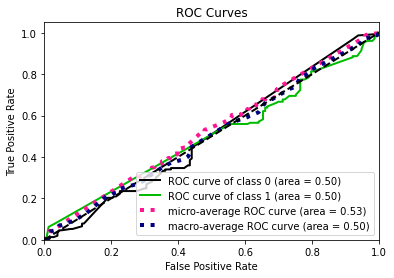

In [16]:
import scikitplot as skplt
import matplotlib.pyplot as plt


y_probas = clf_xbg.predict_proba(X_val)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_val, y_probas)
plt.show()

In [17]:
clf_xbg.save_model('xgb_lstm_gru_mean_Nov21.json')